In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab\ Notebooks/data/Robot_Trials_DL.npy


Mounted at /content/drive
'/content/drive/MyDrive/Colab Notebooks/data/Robot_Trials_DL.npy'


In [ ]:

class preprocessor:
    def __init__(self,file, train,valid,prepend):
        # read data and shuffle it randomly
        data = np.load(file)
        np.random.seed()
        np.random.shuffle(data)
        self.time_length=data.shape[1]
        self.data = data
        self.train_ratio = train
        self.valid_ratio = valid
        _, self.lengths = variable_length(data) 
        self.prepend_len = prepend

        self._design_input_target()
        self._process_data()
        self._prepend(self.prepend_len)
    # function to create training data and target value
    def _design_input_target(self):
        data = self.data
        data_lengths = self.lengths
        data_size, max_len, _ = self.data.shape

        data_angle = data[:, :, 0:1]
        data_ft = data[:, :, 1:2]
        data_fpourable = data[:, :, 2:3]
        data_f2pour = data[:, :, 3:4]
        data_height = data[:, :, 4:5]
        data_diameter = data[:, :, 5:6]
        data_curvature = np.zeros([data_size, max_len, 1])
        for n in range(data_size):
            data_curvature[n, :data_lengths[n], :] = 2 / data_diameter[n, :data_lengths[n], :]
        data_velocity=data[:, :, 6:7]
        # the input contains angle, total amount, target amount, cup height, cup curvature, joint velocity
        data_input = np.concatenate((data_angle,
                                     data_fpourable,
                                     data_f2pour,
                                     data_height,
                                     data_curvature,
                                     data_velocity
                                     ), axis=2)

        # the target is the force reading in the receiving cup
        data_target =  data_ft

        
        self.data_input = data_input
        self.data_target = data_target
       

    def _process_data(self):
            '''
            1. split data into train, valid, and test
            2. normalize the train, valid, and test using the train data
            '''
            data_input = self.data_input
            data_target = self.data_target
            train_ratio = self.train_ratio
            valid_ratio = self.valid_ratio
            #  split the data into three parts: train, validation, test
            data_size = data_input.shape[0]
            data_boundary_train = int(train_ratio * data_size)
            data_boundary_valid = int((train_ratio + valid_ratio) * data_size)
            data_input_train = data_input[:data_boundary_train, :, :]
            data_input_valid = data_input[data_boundary_train:data_boundary_valid, :, :]
            data_input_test = data_input[data_boundary_valid:, :, :]

            # set up the ground truth for each data set
            data_target_train = data_target[:data_boundary_train, :, :]
            data_target_valid = data_target[data_boundary_train:data_boundary_valid, :, :]
            data_target_test = data_target[data_boundary_valid:, :, :]

            # normalize data
            self.mean_train, self.std_train = get_mean_std(data_input_train)
           
            print('mean train', self.mean_train)
            print('std train', self.std_train)
            data_input_train = apply_mean_std(data_input_train, self.mean_train, self.std_train)  # standardize training data

            data_input_valid = apply_mean_std(data_input_valid, self.mean_train, self.std_train)
           
            data_input_test =  apply_mean_std(data_input_test, self.mean_train, self.std_train)
            

            # the data have been normalized
            self.input_train = data_input_train
            self.input_valid = data_input_valid
            self.input_test = data_input_test
            self.target_train = data_target_train
            self.target_valid = data_target_valid
            self.target_test = data_target_test

    def _prepend(self, prepend_length):
        '''
        If this function is called, it must be called as the last step of preprocessing
        :param prepend_length:
        :return:
        '''
        # adjust to new prepend length

        self.input_train = prepend_data(self.input_train, prepend_length)
        self.target_train = prepend_data(self.target_train, prepend_length)
        self.input_valid = prepend_data(self.input_valid, prepend_length)
        self.target_valid = prepend_data(self.target_valid, prepend_length)
        self.input_test = prepend_data(self.input_test, prepend_length)
        self.target_test = prepend_data(self.target_test, prepend_length)

def prepend_data(x, prepend_length):
    '''
    prepend certain amount of data for system stablization
    assumes data is of shape [data_size, max_len, feature_dim]
    We just copy the first time stamp to all the prepended part
    '''
    x_2_prepend = np.tile(x[:, 0:1, :], (1, prepend_length, 1))
    x_prepended = np.concatenate((x_2_prepend, x), axis=1)

    return x_prepended

def variable_length(data):
    '''
    compute the mask and multiple sequence lengths from a zero-padded
    data tensor of size [batch_size, input_size]
    '''
    num_sequences, max_len, feature_dim = data.shape
    data = np.max(np.abs(data), axis=2)  # remove the feature dimension
    mask = np.sign(data)
    lengths = np.sum(mask, axis=1)
    lengths_rnn = lengths.astype(np.int32)
    mask_cost = mask
    # for i in range(data.shape[0]):
    #     mask_cost[i, lengths_rnn[i] - 1] = 0
    
    return (mask_cost, lengths_rnn)
def get_mean_std(data_train):
    '''
    need to disregard the zeros that are manually added
    '''
    _, lengths = variable_length(data_train)
    data_size, _, feature_dim = data_train.shape
    mean_train = np.zeros(feature_dim)
    std_train = np.zeros(feature_dim)
    for d in range(feature_dim):
        degree_list = []
        for n in range(data_size):
            degree_list.append(data_train[n, :lengths[n], d])
        degree_array = np.concatenate(degree_list)
        mean_train[d] = np.mean(degree_array)
        std_train[d] = np.std(degree_array)

    return (mean_train, std_train)


def apply_mean_std(data, mean_train, std_train):
    _, lengths = variable_length(data)
    data_copy = np.copy(data)
    data_size, _, feature_dim = data.shape
    for d in range(feature_dim):
        for n in range(data_size):
            data_copy[n, :lengths[n], d] -= mean_train[d]
            data_copy[n, :lengths[n], d] /= std_train[d]

    return data_copy


In [ ]:
def create_model(dim_input, dim_output, unit, lr,layer, seq_len, dropout=0):
    '''
    Params:
    dim_input: dimension of the input
    dim_output: dimension of the output
    unit: number of rnn units
    layer: number of rnn layers
    seq_len: maximum sequence length
    dropout: % of dropout [0,1)

    Returns:
    model: Neural network model
    '''
    model = tf.keras.Sequential()

    # Adds the input dimension and does not take into consideration zero values of the input sequences
    model.add(tf.keras.layers.Input(shape=(seq_len, dim_input)))
    model.add(tf.keras.layers.Masking(mask_value=0.))

    # Adds the different rnn layers
    for i in range(layer):
       
 
        model.add(tf.keras.layers.LSTM(unit, return_sequences=True))
       
        model.add(tf.keras.layers.Dropout(dropout))

    # Adds the output dense layer
    model.add(tf.keras.layers.Dense(dim_output, activation='linear'))

    # Defines the loss and optimizer with default values
    # opt = tf.keras.optimizers.Adam(learning_rate=0.001)  best at 3/15
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)
    # opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    opt=tf.keras.optimizers.Adamax(learning_rate=lr_schedule)
    model.compile(loss='mean_squared_error', optimizer=opt,metrics=['mean_squared_error'])

    return model



In [ ]:
# data=np.load('/content/drive/MyDrive/Colab Notebooks/data/Robot_Trials_DL.npy')
# new_d=np.load('/content/drive/MyDrive/Colab Notebooks/data/Robot_Trials_DL_Test_30pct.npy')
# print(data.shape)
# print(new_d.shape)
# final_data=np.zeros((721,700,7))
# final_data[:688,:,:] = data
# final_data[688:,:,:] = new_d

# file_path='/content/drive/MyDrive/Colab Notebooks/data/new.npy'
# with open(file_path,'wb') as f:
#   np.save(f,final_data)
data=np.load('/content/drive/MyDrive/Colab Notebooks/data/new.npy')
print(data.shape)

(721, 700, 7)


mean train [-4.33260667e+01  7.12027628e-01  2.37254734e-01  2.22464361e+02
  2.39990008e-02  8.41353155e-02]
std train [3.63629662e+01 2.63122871e-01 1.17534745e-01 8.42060903e+01
 4.18144705e-03 5.25920814e-01]
(504, 760, 6)
(144, 760, 6)
(73, 760, 6)
(504, 760, 1)
(144, 760, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 760, 6)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 760, 256)          269312    
_________________________________________________________________
dropout (Dropout)            (None, 760, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 760, 256)          525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 76

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ZeroDivisionError: ignored

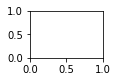

In [ ]:
train_ratio = 0.7
valid_ratio = 0.2
prepend_length = 60
#   data_pour_partial Robot_Trials_DL
preprocessed_data = preprocessor('/content/drive/MyDrive/Colab Notebooks/data/new.npy',
                      train_ratio, valid_ratio, prepend=prepend_length)
print(preprocessed_data.input_train.shape)
print(preprocessed_data.input_valid.shape)

print(preprocessed_data.input_test.shape)
# 3d is target v
print(preprocessed_data.target_train.shape)
print(preprocessed_data.target_valid.shape)
 

 

# best @4:53 ,batch=128 mae dropout 0.2
dim_input = 6
dim_output = 1
unit = 256
layer = 6
# big lr small batch->bad 
# small lr, small batch->ok,but not good
seq_len = preprocessed_data.input_train.shape[1]
epoch=500  
lr=0.001
dropout=0

model = create_model(dim_input, dim_output, unit, lr, layer, seq_len,dropout)
model.summary()
 


# .ckpt  best_model_H
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/data/27_candidate2.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,verbose=1, save_weights_only=True,
                              monitor="val_loss",save_best_only=True,mode='min'

					    )
 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=100)

history=model.fit(x=preprocessed_data.input_train,y=preprocessed_data.target_train,
		  validation_data=(preprocessed_data.input_valid,preprocessed_data.target_valid),
		  batch_size=256,epochs=epoch,verbose=2,callbacks=[cp_callback,early_stopping])


model.load_weights(checkpoint_path)
result = model.predict(x=preprocessed_data.input_test)
 

indexes = np.random.randint(0, 16, size=16)
i = 1
mae_error = 0
mse_error = 0
ground=preprocessed_data.target_test[-73:]
print(ground.shape)
mae_error2=0
mse_error2=0
 
final_data=np.zeros((result.shape[0],preprocessed_data.time_length,result.shape[2]))
# calculate the mae and mse errors for the test set
for idx in range(preprocessed_data.target_test.shape[0]):
    # zero out the padded value
    mark, _ = np.nonzero(preprocessed_data.target_test[idx, :, :])
    result[idx,mark[-1]:,:]=0
    zeros=mark[-1]-60
    mae_error += np.mean(np.abs(result[idx, 60:mark[-1], :] - ground[idx, :zeros, 1:2]))
    mse_error += np.mean(np.square(result[idx, 60:mark[-1], :] - ground[idx, :zeros, 1:2]))
    # remove prepended elements
    final_data[idx,:,0] = result[idx,60:,0]
    mae_error2 += np.mean(np.abs(final_data[idx, :zeros, :] - ground[idx, :zeros, 1:2]))
    mse_error2 += np.mean(np.square(final_data[idx, :zeros, :] - ground[idx, :zeros, 1:2]))
 
i=1
for idx in indexes:

    plt.subplot(4, 4, i)
    i += 1
    chosen = ground[idx, :, 1:2]
    plt.plot(chosen, 'b', label='Ground Truth')
    
    plt.plot(final_data[idx,:,:], 'r', label='Prediction')
 

plt.show()
temp = mae_error / preprocessed_data.target_test.shape[0]
print("MAE loss:", temp)
temp2 = mse_error / preprocessed_data.target_test.shape[0]
print("MSE loss:", temp2)

temp = mae_error2 / preprocessed_data.target_test.shape[0]
print("MAE2 loss:", temp)
temp2 = mse_error2 / preprocessed_data.target_test.shape[0]
print("MSE2 loss:", temp2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()